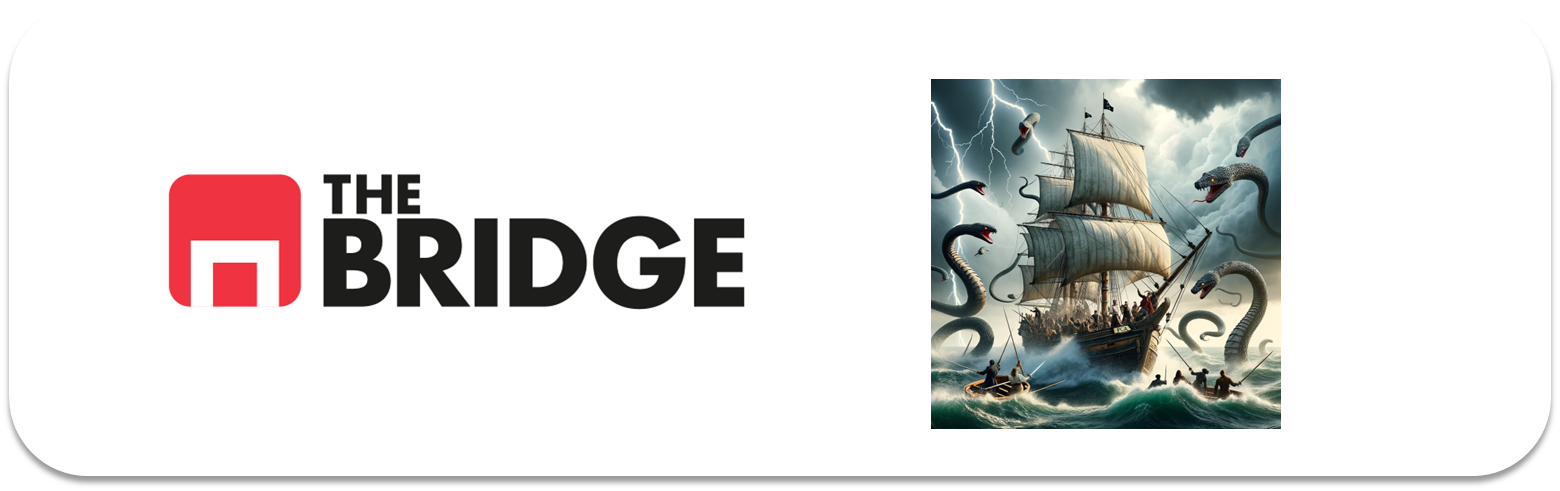

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [6]:
import bootcampviztools as bt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel, RFE, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import recall_score

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


In [4]:
df = pd.read_csv('data/credit_npo.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [5]:
df.head()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0                 0                              0.081892   37   
1                 0                              0.023413   74   
2                 0                              0.000000   43   
3                 0                              0.492754   44   
4                 0                              1.000000   63   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     0   0.070709         5656.0   
1                                     0   0.209197         4870.0   
2                                     0   0.080784         5000.0   
3                                     0   0.412735         7333.0   
4                                     0   0.000000         8333.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               12                        1   
1                                9                        0   
2                                2                        0   
3                                4                        0   
4                                3                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                             0                                     0   
1                             1                                     0   
2                             0                                     0   
3                             2                                     0   
4                             0                                     0   

   NumberOfDependents  
0                 0.0  
1                 0.0  
2                 2.0  
3                 3.0  
4                 1.0

In [7]:
df_cleaned = df.dropna()

In [8]:
# Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.
categorical_features = [
    "NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberRealEstateLoansOrLines",
    "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfOpenCreditLinesAndLoans", "NumberOfDependents"
]

def bin_counts(value):
    if value == 0:
        return "Low"
    elif value <= 2:
        return "Medium"
    else:
        return "High"

for col in categorical_features:
    df_cleaned[col] = df_cleaned[col].apply(bin_counts)

/var/folders/r2/m617yygs46q4sg5bxxgr4c6r0000gn/T/ipykernel_5015/3148344964.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].apply(bin_counts)


In [9]:
# Convert categorical features to numerical
df_encoded = df_cleaned.copy()
for col in categorical_features:
    df_encoded[col] = df_encoded[col].astype("category").cat.codes


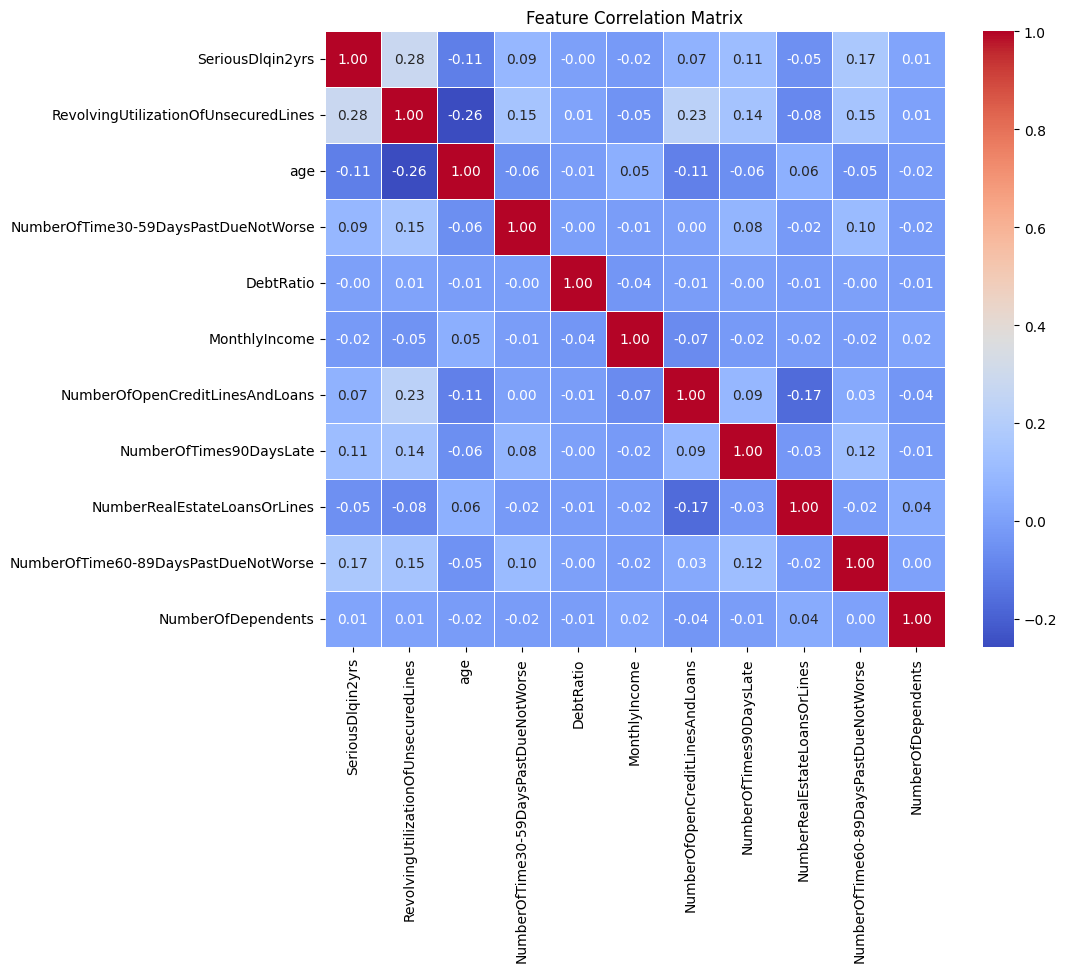

In [13]:
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

In [14]:
correlated_features = set()
threshold = 0.6
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            correlated_features.add(correlation_matrix.columns[i])

correlated_features

set()

In [10]:
X = df_encoded.drop(columns=["SeriousDlqin2yrs"])
y = df_encoded["SeriousDlqin2yrs"]

1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.

    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 

    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)

    4. Selección de las mejores features empleando RFE.

    5. Selección de las mejores features empleando SFS.
    
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).


In [15]:
#SelectKBest (ANOVA) for numeric features
selector_num = SelectKBest(score_func=f_classif, k=4)
X_num_selected = selector_num.fit_transform(X.iloc[:, :4], y)
selected_num_features = X.columns[:4][selector_num.get_support()].tolist()

In [17]:
#Mutual Information for categorical features
mi_scores = mutual_info_classif(X[categorical_features], y, discrete_features=True)
selected_cat_features = X[categorical_features].columns[np.argsort(mi_scores)[-2:]].tolist()


In [18]:
# SelectFromModel (RandomForest)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)
selector_model = SelectFromModel(rf_model, threshold="median", prefit=True)
selected_model_features = X.columns[selector_model.get_support()].tolist()

In [19]:
# Recursive Feature Elimination (RFE)
rfe_selector = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=5)
rfe_selector.fit(X, y)
selected_rfe_features = X.columns[rfe_selector.support_].tolist()


In [20]:
#Sequential Feature Selection (SFS)
sfs_selector = SequentialFeatureSelector(RandomForestClassifier(n_estimators=100, random_state=42), 
                                         n_features_to_select=5, direction="backward", cv=3, n_jobs=-1)
sfs_selector.fit(X, y)
selected_sfs_features = X.columns[sfs_selector.get_support()].tolist()

In [22]:
# Hard Voting for Feature Selection
all_selected_features = [selected_num_features, selected_cat_features, selected_model_features, selected_rfe_features, selected_sfs_features]
feature_votes = pd.Series([f for sublist in all_selected_features for f in sublist]).value_counts()
final_selected_features = feature_votes.index[:6].tolist()

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X[final_selected_features], y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC()
}

In [25]:
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="recall")
    cv_results[name] = np.mean(scores)

best_model_name = max(cv_results, key=cv_results.get)
best_model = models[best_model_name]
best_model


RandomForestClassifier(random_state=42)

Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.

In [27]:
param_grid = {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]}

grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring="recall")
grid_search.fit(X_train, y_train)
best_model_final = grid_search.best_estimator_


In [28]:
y_pred = best_model_final.predict(X_test)
final_recall = recall_score(y_test, y_pred)

print(f"Best Model: Random Forest with recall: {final_recall:.4f}")

Best Model: Random Forest with recall: 0.1737


### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.